# Wedges in `bruges`

Let's make wedge models!

We're going to make **all sorts of models** using one magical function. Here's what it can do:

- Layer-cake models with no dip.
- Wedge models with arbitrary thickness on the left and right.
- Clinoform models.
- Models filled with arbitrary stratigraphy, from constant values to well logs.

All these models can have varying amounts of rock above and below them, and can be extended left and right beyond the wedgy part. You can also dip the wedge in either direction.

**This is a new feature introduced in v0.4.2; if you find bugs, please let us know by [raising an issue](https://github.com/agile-geoscience/bruges/issues).**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import bruges as bg

## The default model and a basic synthetic workflow

We can produce a simple wedge model just by calling the function.

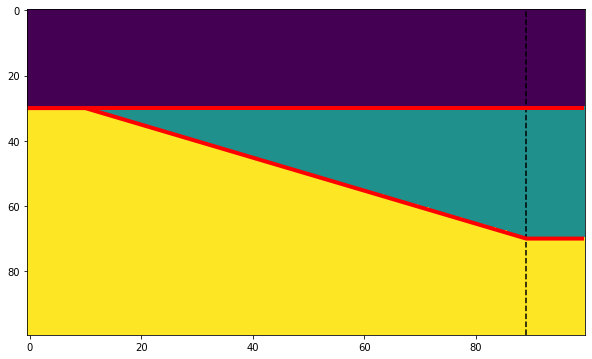

In [57]:
w, top, base, ref = bg.models.wedge()

plt.figure(figsize=(10, 6))
plt.imshow(w, aspect='auto', interpolation='none')
plt.axvline(ref, color='k', ls='--')
plt.plot(top, 'r-', lw=4)
plt.plot(base, 'r-', lw=4)

You can then use this integer model to index into an array of rock properties:

In [3]:
rocks = np.array([2.32 * 2.65,  # Rock index 0
                  2.35 * 2.60,  # Rock index 1
                  2.35 * 2.62,  # Rock index 2
                 ])

# Fancy indexing into the rocks with the model.
impedance = rocks[w]

# Make reflectivity.
rc = (impedance[1:] - impedance[:-1]) / (impedance[1:] + impedance[:-1])

# Get a wavelet.
ricker = bg.filters.ricker(0.064, 0.001, 40)

# Repeated 1D convolution for a synthetic.
syn = np.apply_along_axis(np.convolve, arr=rc, axis=0, v=ricker, mode='same')

<ipython-input-3-05d2101b5478>:13: FutureWarning: In future releases, return_t will be True by default.
  ricker = bg.filters.ricker(0.064, 0.001, 40)
/Users/matt/opt/miniconda3/envs/bruges/lib/python3.8/site-packages/bruges/filters/wavelets.py:272: FutureWarning: In future releases, the default legacy behaviour will be removed. We recommend setting sym=True. This will be the default in v0.5+.
  t = _get_time(duration, dt, sym=sym)


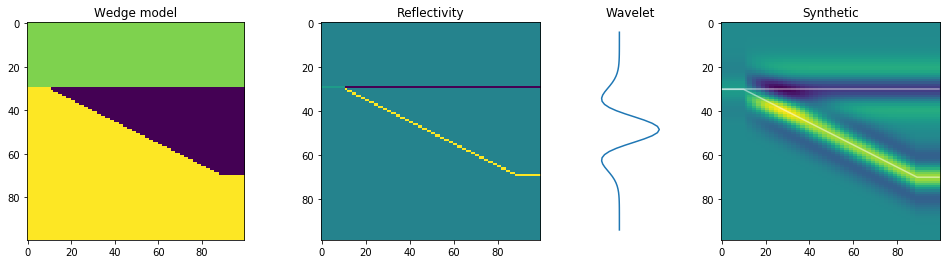

In [56]:
fig, axs = plt.subplots(figsize=(17, 4), ncols=5, gridspec_kw={'width_ratios': (4, 4, 4, 1, 4)})
axs[0].imshow(w)
axs[0].set_title('Wedge model')
axs[1].imshow(impedance)
axs[1].set_title('Impedance')
axs[2].imshow(rc)
axs[2].set_title('Reflectivity')
axs[3].plot(ricker, np.arange(ricker.size))
axs[3].axis('off')
axs[3].set_title('Wavelet')
axs[4].imshow(syn)
axs[4].set_title('Synthetic')
axs[4].plot(top, 'w', alpha=0.5)
axs[4].plot(base, 'w', alpha=0.5)
plt.show()

Note that we could also have made the impedance model directly — it just depends how you want to make your models. 

So we can use the `strat` argument, and pass in the rock properties there. 

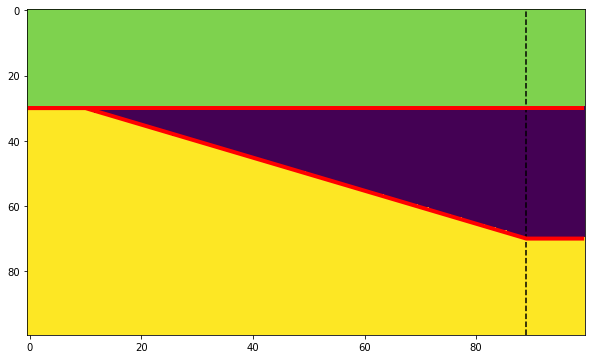

In [5]:
w, top, base, ref = bg.models.wedge(strat=rocks)

plt.figure(figsize=(10, 6))
plt.imshow(w, aspect='auto', interpolation='none')
plt.axvline(ref, color='k', ls='--')
plt.plot(top, 'r-', lw=4)
plt.plot(base, 'r-', lw=4)

## A layered wedge model

We can modify the stratigraphy of any layer. E.g., let's pass `(1, 2, 1, 2, 1)` in as the wedge strat, instead of just `1`. We'll also change the bottom layer to a `3`, so now we have 4 rocks.

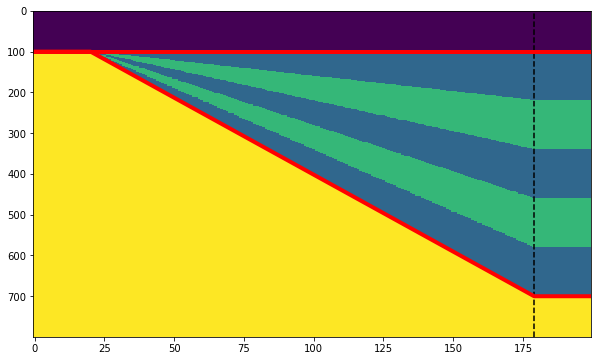

In [6]:
w, top, base, ref = bg.models.wedge(depth=(100, 600, 100),
                                    width=(20, 160, 20),
                                    strat=(0, (1, 2, 1, 2, 1), 3),
                                    mode='linear'
                                   )

plt.figure(figsize=(10, 6))
plt.imshow(w, aspect='auto', interpolation='none')
plt.axvline(ref, color='k', ls='--')
plt.plot(top, 'r-', lw=4)
plt.plot(base, 'r-', lw=4)
plt.show()

Notice that the `wedge` function returns 4 things:

- The wedge model as a 2D NumPy array of ints (or whatever numbers you gave as input).
- The top horizon, in pixel index units, for convenience.
- The base horizon, in pixel index units, for convenience.
- The horizontal (left-right) position, as an integer, of the 'reference' model. You may or may not be interested in this, depending on your application.

If you only want the wedge, you can call the function like so:

    wedge, *_ = bg.models.wedge()

## Arbitrary thicknesses

You can provide the minimum and maximum thickness of the wedge.

**Note:** If the maximum thickness of the wedge if more than 1, then the total depth (i.e. number of rows) of the model will be more than the sum of the `depth` argument, so that the entire model can be accommodated. If you don't want the 'extra' depth, you can slice them off the model as with any NumPy array.

Here's a layer cake:

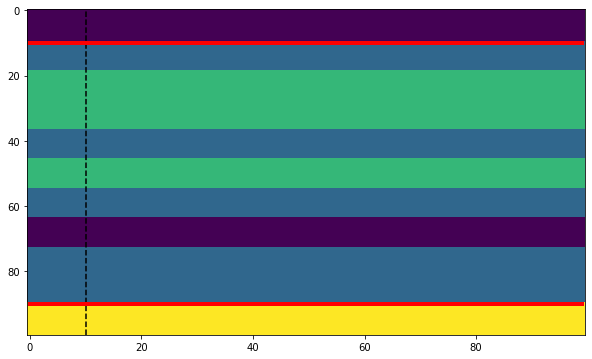

In [7]:
w, top, base, ref = bg.models.wedge(depth=(10., 80, 10),
                          width=(10, 80, 10),
                          strat=(0, (1, 2, 2, 1, 2, 1, 0, 1, 1,), 3),  # Floats in the wedge
                          thickness=(1, 1),
                          mode='linear',
                         )

plt.figure(figsize=(10, 6))
plt.imshow(w, aspect='auto', interpolation='none')
plt.axvline(ref, color='k', ls='--')
plt.plot(top, 'r-', lw=4)
plt.plot(base, 'r-', lw=4)
plt.show()

Here's another example. This time we'll also pass in floats — velocities perhaps.

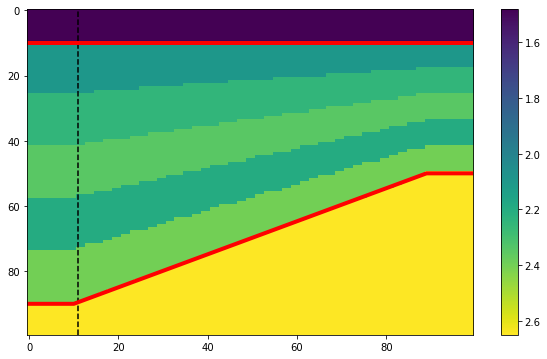

In [8]:
w, top, base, ref = bg.models.wedge(depth=(10., 80, 10),
                          width=(10, 80, 10),
                          strat=(1.48, (2.10, 2.25, 2.35, 2.20, 2.40), 2.65),  # Floats in the wedge
                          thickness=(1, 0.5),
                          mode='linear',
                         )

plt.figure(figsize=(10, 6))
plt.imshow(w, aspect='auto', interpolation='none')
plt.axvline(ref, color='k', ls='--')
plt.plot(top, 'r-', lw=4)
plt.plot(base, 'r-', lw=4)
cb = plt.colorbar()
cb.ax.invert_yaxis()
plt.show()

## Top and bottom conformance

The layers in the wedge can also be top or bottom conforming, rather than proportionally adjusted.

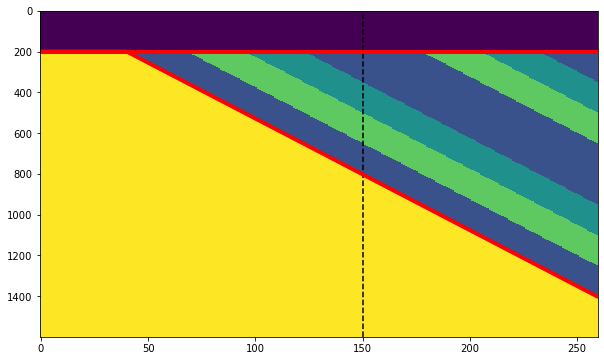

In [9]:
w, top, base, ref = bg.models.wedge(depth=(200, 600, 200),
                          width=(40, 220, 0),
                          strat=(0, (1,2,3,1), 4),
                          mode='linear',
                          conformance='bottom',
                          thickness=(0, 2)
                         )

plt.figure(figsize=(10, 6))
plt.imshow(w, aspect='auto', interpolation='none')
plt.axvline(ref, color='k', ls='--')
plt.plot(top, 'r-', lw=4)
plt.plot(base, 'r-', lw=4)
plt.show()

## Models from well logs

We can pass in arrays as `strat` and they will be used as the values in the model layers.

We'll start by loading a well and making the pieces we want to pass in as `strat`.

The middle piece will be fitted to the middle layer of the wedge (resulting in the number of pixels given in the `depth` argument. The upper and lower pieces will then be cropped to fit their layers, so you must provide enough data for this to happen. The safest thing to do is to provide the _entire_ log above and the same below. The tool `welly` makes this straightforward:

In [25]:
from welly import Well

w = Well.from_las('../data/R-39.las')

log, top, bot = 'GR', 2620, 2720  # The zone we want in the wedge

log_above = w.data[log].to_basis(stop=top)
log_wedge = w.data[log].to_basis(start=top, stop=bot)
log_below = w.data[log].to_basis(start=bot)

Now we can send these pieces to `wedge`; it will squeeze all of `log_wedge` into the 600 pixels allotted to the wedge layer in `depth`. But it will only use the bits of `log_above` and `log_below` that it needs for the 200 pixels above and the 400 below (adjusting for the scale implied by the wedge).

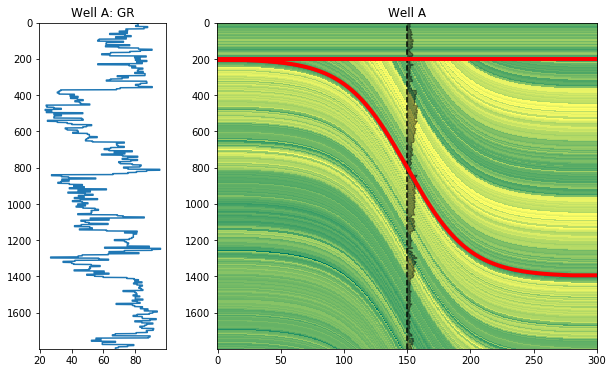

In [26]:
w, top, base, ref = bg.models.wedge(depth=(200, 600, 400),
                          width=(20, 260, 20),
                          strat=(log_above, log_wedge, log_below),
                          mode='sigmoid', conformance='bottom',
                          thickness=(0, 2)
                         )

log = w[:, ref]
depth = np.arange(len(log))

fig, axs = plt.subplots(figsize=(10, 6), ncols=2, gridspec_kw={'width_ratios': (1, 3)})

axs[0].plot(log, depth)
axs[0].set_ylim(depth[-1], depth[0])
axs[0].set_title('Well A: GR')

axs[1].imshow(w, aspect='auto', cmap='summer_r')
axs[1].axvline(ref, color='k', ls='--')
axs[1].plot(top, 'r-', lw=4)
axs[1].plot(base, 'r-', lw=4)
axs[1].fill_betweenx(depth, (10 - log/10)+ref, ref, color='k', alpha=0.4)
axs[1].set_title('Well A')

plt.show()

---
&copy; 2021 Agile Scientific, licensed CC-BY / Apache 2.0